In [352]:
import stock_helper
import pandas as pd
from datetime import datetime
import numpy as np

# MSFT > tesla > google > amd > ge
dataset = stock_helper.fetch_stock_data('MSFT', '30y')

In [353]:
df = stock_helper.generate_indicators(dataset, 
                                      timeperiod=2, 
                                      generate_target=True, 
                                      reset_index=True)

# Convert date to the n-th day from 1970-01-01
df['date'] = df['date'].apply(lambda date64: (date64 - np.datetime64('1970-01-01T00:00:00')) / np.timedelta64(1, 'D'))

In [354]:
df.head()

,date,high,low,open,close,volume,RSI,MOM,slowk,slowd,macd,macdsignal,macdhist,ADX,SMA,upper_bb,middel_bb,lower_bb,next_2day_trend
0,7802.0,0.915234,0.893180,0.910824,0.909721,68745600,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
1,7803.0,0.910824,0.888770,0.905310,0.893181,58816800,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
2,7804.0,0.886564,0.852381,0.884359,0.864510,111160800,0.000000,-0.045210,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
3,7805.0,0.882154,0.868922,0.875537,0.876640,70243200,34.920120,-0.016541,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
4,7806.0,0.877743,0.864511,0.873332,0.875537,44812800,32.835867,0.011027,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1


In [355]:
df = df.drop(columns = ["RSI", "MOM", "slowk", "slowd", "macd", "macdsignal", "macdhist", "ADX", "SMA", "upper_bb", "middel_bb", "lower_bb"])

df.head()

,date,high,low,open,close,volume,next_2day_trend
0,7802.0,0.915234,0.893180,0.910824,0.909721,68745600,0
1,7803.0,0.910824,0.888770,0.905310,0.893181,58816800,0
2,7804.0,0.886564,0.852381,0.884359,0.864510,111160800,1
3,7805.0,0.882154,0.868922,0.875537,0.876640,70243200,0
4,7806.0,0.877743,0.864511,0.873332,0.875537,44812800,1


In [356]:
df = df.drop(columns = ["date"])

df.head()

,high,low,open,close,volume,next_2day_trend
0,0.915234,0.893180,0.910824,0.909721,68745600,0
1,0.910824,0.888770,0.905310,0.893181,58816800,0
2,0.886564,0.852381,0.884359,0.864510,111160800,1
3,0.882154,0.868922,0.875537,0.876640,70243200,0
4,0.877743,0.864511,0.873332,0.875537,44812800,1


In [357]:
df = df.dropna()


#split data randomly
from sklearn.model_selection import train_test_split

# target_name = df.columns[-1]

# train_X, test_X, train_y, test_y = train_test_split(df.drop(target_name, axis = 1), df[target_name], test_size=0.10, random_state=4)

train_size = int(len(df) * 0.8)
train = df.iloc[:train_size, :]
test = df.iloc[train_size:, :]

target_name = df.columns[-1]
train_X = train.drop(target_name, axis = 1)
train_y = train[target_name]

test_X = test.drop(target_name, axis = 1)
test_y = test[target_name]

In [358]:
from sklearn.tree import DecisionTreeClassifier

clf = DecisionTreeClassifier(max_depth=2)
clf.fit(train_X, train_y)
prediction = clf.predict(test_X)

from sklearn.metrics import accuracy_score
accuracy_score(test_y, prediction)

0.42724867724867727

In [359]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(max_depth=5)
clf.fit(train_X, train_y)
prediction = clf.predict(test_X)

accuracy_score(test_y, prediction)

0.42658730158730157

In [360]:
from sklearn.tree import DecisionTreeClassifier

clf = DecisionTreeClassifier(max_depth=4)
clf.fit(train_X, train_y)
prediction = clf.predict(test_X)

from sklearn.metrics import accuracy_score
accuracy_score(test_y, prediction)

0.43253968253968256

In [361]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(max_depth=8)
clf.fit(train_X, train_y)
prediction = clf.predict(test_X)

accuracy_score(test_y, prediction)

0.4226190476190476

In [362]:
from sklearn.feature_extraction.text import CountVectorizer

count_vect = CountVectorizer()
x_train_counts = count_vect.fit_transform(train_X).toarray()
x_test_counts = count_vect.transform(test_X).toarray()

In [363]:
x_train_counts.shape

(5, 5)

In [364]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

clf = LogisticRegression()
clf.fit(train_X, train_y)

hyp = clf.predict(test_X)
accuracy_score(test_y, hyp)

0.5773809523809523

In [365]:
train_X

,high,low,open,close,volume
0,0.915234,0.893180,0.910824,0.909721,68745600
1,0.910824,0.888770,0.905310,0.893181,58816800
2,0.886564,0.852381,0.884359,0.864510,111160800
3,0.882154,0.868922,0.875537,0.876640,70243200
4,0.877743,0.864511,0.873332,0.875537,44812800
...,...,...,...,...,...
6039,43.630966,43.202511,43.363182,43.434589,38937300
6040,43.622048,43.006146,43.175741,43.059704,34039500
6041,42.988291,42.229571,42.684802,42.488426,50369200
6042,42.640169,41.078095,42.461646,41.310173,52433000


In [366]:
train_y

0       0
1       0
2       1
3       0
4       1
       ..
6039    0
6040    0
6041    0
6042    1
6043    1
Name: next_2day_trend, Length: 6044, dtype: int64

In [367]:
train_x_2 = train_X.copy()

train_y_2 = train_y.copy()

test_x_2 = test_X.copy()

test_y_2 = test_y.copy()

In [368]:
df2 = df.copy()



In [369]:
# Helper Functions
# In order to print all performance metrics relevant to a regression task (such as MAE and R-square), we will be defining the regression_results function.

import sklearn.metrics as metrics
def regression_results(y_true, y_pred):
    # Regression metrics
    explained_variance=metrics.explained_variance_score(y_true, y_pred)
    mean_absolute_error=metrics.mean_absolute_error(y_true, y_pred) 
    mse=metrics.mean_squared_error(y_true, y_pred) 
    mean_squared_log_error=metrics.mean_squared_log_error(y_true, y_pred)
    median_absolute_error=metrics.median_absolute_error(y_true, y_pred)
    r2=metrics.r2_score(y_true, y_pred)
    print('explained_variance: ', round(explained_variance,4))    
    print('mean_squared_log_error: ', round(mean_squared_log_error,4))
    print('r2: ', round(r2,4))
    print('MAE: ', round(mean_absolute_error,4))
    print('MSE: ', round(mse,4))
    print('RMSE: ', round(np.sqrt(mse),4))

In [370]:
# use the difference between today and today - 1, today - 1 and today - 2, ... today - 4 and today - 5

df3 = pd.DataFrame()

for columnName in df2.columns:
    if columnName != "volume" and columnName != "next_2day_trend":
        column = df2[[columnName]]

        df3.loc[:,'shift1' + columnName] = (df2.loc[:,columnName].shift() - df2.loc[:,columnName]) / df2.loc[:,columnName]

        df3.loc[:,'shift2' + columnName] = (df2.loc[:,columnName].shift().shift() - df2.loc[:,columnName].shift()) / df2.loc[:,columnName]

        df3.loc[:,'shift3' + columnName] = (df2.loc[:,columnName].shift().shift().shift() - df2.loc[:,columnName].shift().shift()) / df2.loc[:,columnName]

        df3.loc[:,'shift4' + columnName] = (df2.loc[:,columnName].shift().shift().shift().shift() - df2.loc[:,columnName].shift().shift().shift()) / df2.loc[:,columnName]

        df3.loc[:,'shift5' + columnName] = (df2.loc[:,columnName].shift().shift().shift().shift().shift() - df2.loc[:,columnName].shift().shift().shift().shift()) / df2.loc[:,columnName]


#add volumn and and next_5day_trend, then drop na
# df3["date"] = df2["date"]
df3["volume"] = df2["volume"]
df3["next_2day_trend"] = df2["next_2day_trend"]

df3 = df3.dropna()



In [371]:
df3.head()

,shift1high,shift2high,shift3high,shift4high,shift5high,shift1low,shift2low,shift3low,shift4low,shift5low,...,shift3open,shift4open,shift5open,shift1close,shift2close,shift3close,shift4close,shift5close,volume,next_2day_trend
5,-0.005000,0.005000,0.005000,0.027501,0.004999,0.002558,0.005115,-0.019182,0.042200,0.005114,...,0.010050,0.023869,0.006281,0.001261,0.001261,-0.013871,0.032787,0.018915,65937600,1
6,-0.031478,-0.004843,0.004843,0.004842,0.026635,-0.017588,0.002513,0.005025,-0.018844,0.041458,...,0.002506,0.010025,0.023810,-0.028187,0.001225,0.001225,-0.013480,0.031863,83570400,1
7,-0.032786,-0.030446,-0.004684,0.004684,0.004684,-0.026895,-0.017115,0.002445,0.004890,-0.018338,...,-0.004866,0.002433,0.009733,-0.044496,-0.026933,0.001171,0.001171,-0.012880,88783200,1
8,-0.027335,-0.031890,-0.029613,-0.004556,0.004556,-0.044392,-0.025701,-0.016355,0.002336,0.004673,...,-0.002337,-0.004673,0.002336,-0.025114,-0.043379,-0.026256,0.001141,0.001141,67752000,1
9,-0.024444,-0.026667,-0.031111,-0.028889,-0.004445,-0.022831,-0.043379,-0.025114,-0.015982,0.002283,...,-0.027272,-0.002274,-0.004545,-0.004546,-0.024999,-0.043181,-0.026137,0.001136,67932000,1


In [372]:
train_size = int(len(df3) * 0.8)
train = df3.iloc[:train_size, :]
test = df3.iloc[train_size:, :]

target_name = df.columns[-1]
train_X = train.drop(target_name, axis = 1)
train_y = train[target_name]

test_X = test.drop(target_name, axis = 1)
test_y = test[target_name]

In [373]:
train_X.head()

,shift1high,shift2high,shift3high,shift4high,shift5high,shift1low,shift2low,shift3low,shift4low,shift5low,...,shift2open,shift3open,shift4open,shift5open,shift1close,shift2close,shift3close,shift4close,shift5close,volume
5,-0.005000,0.005000,0.005000,0.027501,0.004999,0.002558,0.005115,-0.019182,0.042200,0.005114,...,0.002512,0.010050,0.023869,0.006281,0.001261,0.001261,-0.013871,0.032787,0.018915,65937600
6,-0.031478,-0.004843,0.004843,0.004842,0.026635,-0.017588,0.002513,0.005025,-0.018844,0.041458,...,-0.005012,0.002506,0.010025,0.023810,-0.028187,0.001225,0.001225,-0.013480,0.031863,83570400
7,-0.032786,-0.030446,-0.004684,0.004684,0.004684,-0.026895,-0.017115,0.002445,0.004890,-0.018338,...,-0.002434,-0.004866,0.002433,0.009733,-0.044496,-0.026933,0.001171,0.001171,-0.012880,88783200
8,-0.027335,-0.031890,-0.029613,-0.004556,0.004556,-0.044392,-0.025701,-0.016355,0.002336,0.004673,...,-0.028037,-0.002337,-0.004673,0.002336,-0.025114,-0.043379,-0.026256,0.001141,0.001141,67752000
9,-0.024444,-0.026667,-0.031111,-0.028889,-0.004445,-0.022831,-0.043379,-0.025114,-0.015982,0.002283,...,-0.038636,-0.027272,-0.002274,-0.004545,-0.004546,-0.024999,-0.043181,-0.026137,0.001136,67932000


In [374]:
def result_transfer(foloatValue):
    if foloatValue > 0.5:
        return 1
    else:
        return 0

LR: 0.549967
RFR: 0.521509
DT: 0.519523
NN: 0.423561
KNN: 0.512905
RF: 0.499669
SVR: 0.579749


<BarContainer object of 7 artists>

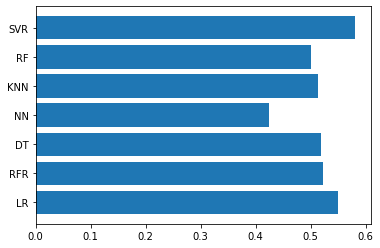

In [375]:
# //TODO: use cross-validation!!!

import matplotlib.pyplot as plt
from sklearn.model_selection import TimeSeriesSplit
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.tree import DecisionTreeClassifier

# Spot Check Algorithms
models = []
models.append(('LR', LinearRegression()))
models.append(('RFR', RandomForestClassifier()))
models.append(('DT', DecisionTreeClassifier()))
models.append(('NN', MLPRegressor(solver = 'lbfgs', max_iter = 500)))  #neural network
models.append(('KNN', KNeighborsRegressor())) 
models.append(('RF', RandomForestRegressor(n_estimators = 10))) # Ensemble method - collection of many decision trees
models.append(('SVR', SVR(gamma='auto'))) # kernel = linear
# Evaluate each model in turn
results = []
names = []
for name, model in models:
    # TimeSeries Cross validation
#     tscv = TimeSeriesSplit(n_splits=3)
    
#     cv_results = cross_val_score(model, train_X, train_y, cv=tscv, scoring='r2')
    clf = model
    clf.fit(train_X, train_y)

    hyp = []
    for i in clf.predict(test_X):
        hyp.append(result_transfer(i))
#     print(hyp)
    
#     = clf.predict(test_X).apply(result_transfer)
#     accuracy_score(test_y, hyp)
    
    results.append(accuracy_score(test_y, hyp))
    names.append(name)
    print('%s: %f' % (name, accuracy_score(test_y, hyp)))
    
# Compare Algorithms
plt.barh(names, results)

In [376]:
# //TODO: use cross-validation!!!

In [377]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

clf = LogisticRegression()
clf.fit(train_X, train_y)

hyp = clf.predict(test_X)
accuracy_score(test_y, hyp)

0.5777630708140304

In [378]:
train_X.head()

,shift1high,shift2high,shift3high,shift4high,shift5high,shift1low,shift2low,shift3low,shift4low,shift5low,...,shift2open,shift3open,shift4open,shift5open,shift1close,shift2close,shift3close,shift4close,shift5close,volume
5,-0.005000,0.005000,0.005000,0.027501,0.004999,0.002558,0.005115,-0.019182,0.042200,0.005114,...,0.002512,0.010050,0.023869,0.006281,0.001261,0.001261,-0.013871,0.032787,0.018915,65937600
6,-0.031478,-0.004843,0.004843,0.004842,0.026635,-0.017588,0.002513,0.005025,-0.018844,0.041458,...,-0.005012,0.002506,0.010025,0.023810,-0.028187,0.001225,0.001225,-0.013480,0.031863,83570400
7,-0.032786,-0.030446,-0.004684,0.004684,0.004684,-0.026895,-0.017115,0.002445,0.004890,-0.018338,...,-0.002434,-0.004866,0.002433,0.009733,-0.044496,-0.026933,0.001171,0.001171,-0.012880,88783200
8,-0.027335,-0.031890,-0.029613,-0.004556,0.004556,-0.044392,-0.025701,-0.016355,0.002336,0.004673,...,-0.028037,-0.002337,-0.004673,0.002336,-0.025114,-0.043379,-0.026256,0.001141,0.001141,67752000
9,-0.024444,-0.026667,-0.031111,-0.028889,-0.004445,-0.022831,-0.043379,-0.025114,-0.015982,0.002283,...,-0.038636,-0.027272,-0.002274,-0.004545,-0.004546,-0.024999,-0.043181,-0.026137,0.001136,67932000


In [327]:
from sklearn.tree import DecisionTreeClassifier

clf = DecisionTreeClassifier()
clf.fit(train_X, train_y)
prediction = clf.predict(test_X)

from sklearn.metrics import accuracy_score
accuracy_score(test_y, prediction)

0.4956982131039047

In [299]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier()
clf.fit(train_X, train_y)
prediction = clf.predict(test_X)

accuracy_score(test_y, prediction)

0.5238095238095238

In [235]:
train_X.head()

,shift1high,shift2high,shift3high,shift4high,shift5high,shift1low,shift2low,shift3low,shift4low,shift5low,...,shift2open,shift3open,shift4open,shift5open,shift1close,shift2close,shift3close,shift4close,shift5close,volume
5,0.000463,0.033349,0.017415,-0.040760,-0.046503,-0.007453,-0.002962,0.052360,-0.081693,-0.043379,...,0.059838,-0.004669,-0.092806,-0.009624,-0.017700,-0.010472,0.041979,-0.010101,-0.073858,7128620
6,-0.006168,0.000460,0.033143,0.017308,-0.040508,-0.009745,-0.007380,-0.002933,0.051850,-0.080897,...,0.000093,0.058094,-0.004533,-0.090102,0.016580,-0.017993,-0.010645,0.042675,-0.010268,6241307
7,0.029671,-0.006351,0.000474,0.034126,0.017822,0.036075,-0.010097,-0.007646,-0.003039,0.053720,...,-0.029920,0.000095,0.059650,-0.004654,0.040584,0.017253,-0.018724,-0.011077,0.044407,5221498
8,0.017163,0.030180,-0.006460,0.000482,0.034712,-0.001468,0.036022,-0.010082,-0.007635,-0.003034,...,0.027566,-0.030792,0.000098,0.061388,-0.003517,0.040442,0.017193,-0.018658,-0.011038,4941252
9,0.007187,0.017287,0.030397,-0.006507,0.000486,0.024982,-0.001505,0.036922,-0.010334,-0.007826,...,0.029017,0.027459,-0.030672,0.000097,0.021147,-0.003591,0.041297,0.017556,-0.019052,9181687
